In [1]:
%%time
# This is the code you want to measure the execution time of
for i in range(1000000):
    x = i ** 2
    
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#to get rid of chained assignment errors
pd.options.mode.chained_assignment = None  # default='warn'
df = pd.read_csv('data/survey_results_public.csv')
schema_df = pd.read_csv('data/survey_results_schema.csv', index_col='qname')
df.set_index('ResponseId', inplace=True)
pd.set_option('display.max_columns',85)# applys to both df's schema and results
pd.set_option('display.max_rows',85) # applys to both df's schema and results

# looking at general Df, getting the count of total responses to put counts into perspective:
#df.columns
#schema_df.columns
#display(df.shape)
#display(schema_df.shape)
#df.head(10)
#schema_df(10)

# looking at country list, and how many have non np.NAN answers:
#print(df['Country'].unique())
#display(df['Country'].count())
#note there are 1497 NaN's


# looking at countries with the most responses, taking top 45 for now, getting total sum from those 45:
#display(df['Country'].value_counts(dropna=False,sort=True,ascending=False).head(45))
#display(np.sum(df['Country'].value_counts(dropna=True,sort=True,ascending=False).head(45)))

# Creating a df_45 DataFrame of the countries and thier respective number of partisipants.(Where I will add aggragated data): 
a = df['Country'].value_counts(dropna=True)
#display(a)
#print(type(a)) 
df_45 = a.to_frame().rename(columns={'Country': 'Count'}) #this turns series into a Df
#print(type(df_45))
# Removing unwated rows (coutries with low partisipation):
filt = df_45['Count']>316
test= df_45[filt]
#display(test)
# Setting up df_45:
df_45 = test
df_45.shape
df_45 = df_45.reset_index()
df_45 = df_45.rename(columns={'index': 'Country'})
#df_45

# Creatig a list of the countries: 
countries = test.index.tolist()
# looking at list:
#display(countries)

# Updating original DF to only include rows from the 45 chosen countries
filt2 = df['Country'].isin(countries)
df_whole_45 = df[filt2]
#df_whole_45

# 64084 matches sum from above, should be correct
#df_whole_45.shape

CPU times: total: 3 s
Wall time: 3.33 s


In [2]:
#getting some specifics on Df_45 changes
#df['Country'].nunique() #180 total original country answers 

df.shape # (73268, 78)
df_whole_45.shape # (64084, 78)

(64084, 78)

In [3]:
country_replace_dict = {'United Kingdom of Great Britain and Northern Ireland':'UK of GB and N.Ireland',
 'United States of America':'USA',
 'Iran, Islamic Republic of...':'Islamic Rplb of Iran',
 'Venezuela, Bolivarian Republic of...':'Venezuela'}
 

df_whole_45['Country'] = df_whole_45['Country'].replace(country_replace_dict)
#df_whole_45
df_45['Country'] = df_45['Country'].replace(country_replace_dict)

In [4]:

### % Fully Remote:

# Group by country:
country_grp = df_whole_45.groupby(['Country'])

# Creating a series for the fractions/percentages of work locations for each country:
remote_work_perc = country_grp['RemoteWork'].value_counts(normalize=True) # normalize=True, puts it into a fraction
# Looking at the series fractions/percentages of work locations for each country:
#print((remote_work_perc))

# filter the series (remote_work_perc) DataFrame to only include rows where the value of the 'RemoteWork' column is 'Fully remote':
fully_remote_perc = remote_work_perc.loc[:, 'Fully remote'].rename('fully_remote_perc')
# Looking at the series where the value of the 'RemoteWork' column is 'Fully remote'
#print(type(fully_remote_perc))
#print((fully_remote_perc))

# Fully remote series added to df_45
# Join the series fully_remote_perc with the df_45:
df_45 = df_45.join(fully_remote_perc, on='Country')
# Create a count of participation: 
Work_Location_Count = country_grp['RemoteWork'].count().rename('Work_Location Count_nonNA')
#print(type(Work_Location_Count))
# Join the series Work_Location_Count with the df_45:
df_45 = df_45.join(Work_Location_Count, on='Country')



-------shape before outliers removal--------
(64084, 80)
------------shape after outliers removal------------
(33561, 80)

This shows that 33561 out of 64084 individuals answered responsibly when giving salary. 

In [5]:
#df_whole_45.columns

#####can I move this to the bottom?
#Sending df_whole_45 to CSV
#df_whole_45.to_csv('df_whole_45.csv', index = False)

In [6]:
###  looking at YearsCode   ###:
#df_whole_45['YearsCode'].unique()

# Fix data in 'years code'
# Replacing/rewriting string responses with float values:
df_whole_45.loc[df_whole_45['YearsCode'] == 'Less than 1 year', 'YearsCode'] = 0
df_whole_45.is_copy = False
df_whole_45.loc[df_whole_45['YearsCode'] == 'More than 50 years', 'YearsCode'] = 51
df_whole_45.is_copy = False
# Ensuring Everything is a float, I had a few error messages to compete with.
df_whole_45.loc[:, 'YearsCode'] = df_whole_45['YearsCode'].astype(float)
#df_whole_45['YearsCode'] = df_whole_45['YearsCode'].astype(float)
# This is_copy = Fales is to cancel out errors/warnings I kept getting. 
df_whole_45.is_copy = False

#df_whole_45.loc[:, 'Age'] = df_whole_45['Age']
    
#checking again
#df_whole_45['YearsCode'].unique()
#df_whole_45.dropna(subset=['Age'], inplace=True)

#get Mean and Median
#display(df_whole_45['YearsCode'].mean())
#df_whole_45['YearsCode'].median()  

#Looking at results:
country_grp = df_whole_45.groupby(['Country'])
#country_grp['YearsCode'].mean().round(1)
#country_grp['YearsCode'].median().round(1)
country_grp['YearsCode'].agg(['mean', 'median']).round(1)
# checking participation 
country_grp['YearsCode'].count()


#yearsCode series added to df_45
Mean_YearsCode = country_grp['YearsCode'].mean().round(1).rename('Mean YearsCode')
Median_YearsCode = country_grp['YearsCode'].median().round(1).rename('Median YearsCode')
YearsCode_Count_NonNA = country_grp['YearsCode'].count().rename('YearsCode_Count NonNA')
df_45 = df_45.join(Mean_YearsCode, on='Country')
df_45 = df_45.join(Median_YearsCode, on='Country')
df_45 = df_45.join(YearsCode_Count_NonNA, on='Country')


C:\Users\Adison\AppData\Local\Temp\ipykernel_8704\128316929.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_whole_45.loc[:, 'YearsCode'] = df_whole_45['YearsCode'].astype(float)


25-34 years old       24920
18-24 years old       14373
35-44 years old       12798
45-54 years old        4957
Under 18 years old     3409
55-64 years old        1915
65 years or older       530
Prefer not to say       469
Name: Age, dtype: int64

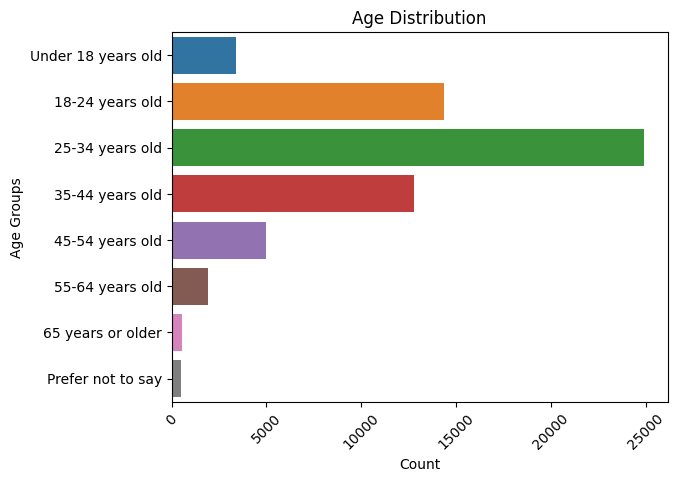

In [7]:
###  looking at age Distribution  ###:
df_whole_45['Age'].unique()
display(df_whole_45['Age'].value_counts())
age_counts = df_whole_45['Age'].value_counts()

#

age_order = [
    'Under 18 years old',
    '18-24 years old',
    '25-34 years old',
    '35-44 years old',
    '45-54 years old',
    '55-64 years old',
    '65 years or older',
    'Prefer not to say'
]

sns.barplot(x=age_counts, y=age_counts.index, order=age_order, orient='h')

plt.ylabel('Age Groups')
plt.xlabel('Count')
plt.title('Age Distribution')
plt.xticks(rotation=45)
plt.show()


In [8]:
###  looking at age Distribution  ###:
# What is the data type? It is in ranges.
#df_whole_45['Age'].unique()
#df_whole_45['Age'].value_counts()

#looking at country group 'age'
#country_grp['Age'].value_counts().head(50)
# Note: after looking at the responses split by coutry, they all have the same most common answer of '25-34 years old'.
        # This is not helpful or intersting. I am going to replace each range with the year in the center of the range 
        # and then take the average. This will represent the spread and weight of the ages in each country.
        
def change_age(age):
    if pd.isna(age):
        return np.NaN
    elif age == "Prefer not to say":
        return np.NaN
    elif age == "Under 18 years old":
        return 16
    elif age == "18-24 years old":
        return 21
    elif age == "25-34 years old":
        return 29.5
    elif age == "35-44 years old":
        return 39.5
    elif age == "45-54 years old":
        return 49.5
    elif age == "55-64 years old":
        return 55.9
    elif age == "65 years or older":
        return 70
    else:
        raise ValueError("Invalid interval value: {}".format(age))    
        
# NOTE: Overwriting ages in df_whole_45 from ranges in to floats. This is permanant and need only run once per eval.
#       If "text Change_age already complete" appears then it has run already.


# Function to  change age, checks first if changes have been made to avoide errors.   
if df_whole_45.iloc[1]['Age'] in [16,21,29.5,39.5,49.5,55.9,70]:
        print("Change_age already complete")
else:df_whole_45.loc[:, 'Age'] = df_whole_45['Age'].apply(change_age)


#looking at age distribution after change, looks good
# df_whole_45['Age'].unique()
# df_whole_45['Age'].value_counts()
# country_grp['Age'].value_counts().head(50)

# Getting average by country:
#country_grp['Age'].mean().round(1)

# Recording participation: 
country_grp = df_whole_45.groupby(['Country'])
country_grp['Age'].count()

#Age series added to df_45
Mean_Age = country_grp['Age'].mean().round(1).rename('Mean Age')
Age_Count_NonNA = country_grp['Age'].count().rename('Age_Count NonNA')
df_45 = df_45.join(Mean_Age, on='Country')
df_45 = df_45.join(Age_Count_NonNA, on='Country')


C:\Users\Adison\AppData\Local\Temp\ipykernel_8704\3915088024.py:41: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  else:df_whole_45.loc[:, 'Age'] = df_whole_45['Age'].apply(change_age)


In [9]:
### Education level ###:
country_grp = df_whole_45.groupby(['Country'])
#country_grp['EdLevel'].unique()
#country_grp['EdLevel'].value_counts().head(40)
#country_grp = df_whole_45.groupby(['Country'])

Top_Education_per_country = country_grp['EdLevel'].apply(lambda x: x.value_counts().index[0])

# Replace original education levels with simplified versions:
replace_dict = {
    'Some college/university study without earning a degree': 'Some college',
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'Bachelor’s',
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'Master’s'
}

# education level added to df_45 
Top_Education_per_country = Top_Education_per_country.replace(replace_dict).rename('Most_Common ED_Level')
df_45 = df_45.join(Top_Education_per_country, on='Country')
Ed_level_Count_NonNA= country_grp['EdLevel'].count().rename('Ed_level Count NonNA')
df_45 = df_45.join(Ed_level_Count_NonNA, on='Country')
print(Top_Education_per_country)

#updating df_whole_45 EdLevel
df_whole_45['EdLevel'] = df_whole_45['EdLevel'].replace(replace_dict)




Country
Argentina                                                      Some college
Australia                                                        Bachelor’s
Austria                                                            Master’s
Bangladesh                                                       Bachelor’s
Belgium                                                          Bachelor’s
Brazil                                                           Bachelor’s
Bulgaria                                                         Bachelor’s
Canada                                                           Bachelor’s
China                                                            Bachelor’s
Colombia                                                         Bachelor’s
Czech Republic                                                     Master’s
Denmark                                                          Bachelor’s
Egypt                                                            Bachelor’s
Finl

In [10]:
### Salary Investigation ###:
# In this section I take a look at the salary data, then add a column of converted salaries. 
# After that I look at the results of converted salaries. There is a considerable amount of commented out code in this cell, 
# Generally it is for my records to remember what I saw when I looked at several of the queries, plots and results.



# Setting options to keep results in floats not scientific notation:
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

# Looking at currencies in the new df to see how many I need to look up:
#print(df_whole_45['Currency'].unique())
#print(df_whole_45['Currency'].value_counts())


# Define dict of currency converters:
currencies_converters = {'EUR': .93, 'USD': 1, 'INR': 82.31, 'GBP': .82,'CAD': 1.37, 'BRL': 5.25, 'PLN': 4.39, 'AUD': 1.5,
                         'SEK': 10.4, 'RUB': 80.2, 'CHF': .91, 'TRY': 19.24,'ILS' : 3.58, 'CZK': 21.47, 'IRR': 42250,
                         'PKR': 288.25, 'DKK': 6.83,'MXN': 18.31, 'NOK': 10.44,'ZAR': 18.05, 'NZD':1.58, 'RON': 4.53, 'BDT': 107.52, 'HUF': 344.99 ,
                         'CNY': 6.88, 'IDR': 14959, 'UAH': 36.95 , 'JPY': 131.30, 'ARS': 211.23, 'BGN': 1.79, 'COP': 4584.75, 'PHP': 54.50,
                         'EGP': 30.90, 'NGN': 464.50, 'VND': 23467.50, 'AED': 3.67} # taken from google converter 3/14/2023 and 4/5

# Trimming unneeded characters from 'Currency':
df_whole_45['Currency'] = df_whole_45['Currency'].str[:3]

# Function to convert currency:
def convert_currency(currency):
    if currency in currencies_converters:
        return currencies_converters[currency]
    else:
        return np.NaN  # using np.NaN instead of NaN
    
# Add new 'CurrencyConvert' column to DataFrame using apply() method:
df_whole_45['CurrencyConvert'] = df_whole_45['Currency'].apply(convert_currency)

# What was the question exactly that people responed to? Getting this information from other Df.
#schema_df.loc['CompTotal']['question']
#OUTPUT: 'What is your current total compensation (salary, bonuses, and perks, before taxes and deductions)? 
#         Please enter a whole number in the box below, without any punctuation.  
#         If you are paid hourly, please estimate an equivalent weekly, monthly, or yearly salary.
#         If you prefer not to answer, please leave the box empty.'


#schema_df.loc['CompFreq']['question']
#OUTPUT: 'Is that compensation weekly, monthly, or yearly?'



#       Note, there seems to be little consistency with responses on salary,
#       it appears some answered with their yearly pay amount and specified the interval payments are received,
#       while others answered the amount they are paid at each interval(intention of questions)...
#       As well as people who blatantly provided misinformation. 

#After looking at the questions and some of the results, I think I need to multiply the pay frequency by the 'CompTotal'

# Function to adjust pay from interval to yearly:
def get_interval(interval):
    if pd.isna(interval):
        return np.NaN
    elif interval == "Yearly":
        return 1
    elif interval == "Monthly":
        return 12
    elif interval == "Weekly":
        return 52
    else:
        raise ValueError("Invalid interval value: {}".format(interval))
        
        
# Decided to multiply frequency of pay by the 'CompTotal', it was the original intention and it looks to give more reasonable rows.        
# Use function - testing if the comp freq gets more results when removed:
df_whole_45['YearlyTotConvertCOMP'] = (1/df_whole_45['CurrencyConvert']) * df_whole_45['CompTotal'] * df_whole_45['CompFreq'].apply(get_interval)
# Use function - testing if the comp freq gets more results when removed:
#df_whole_45['YearlyTotConvertCOMP'] = (1/df_whole_45['CurrencyConvert']) * df_whole_45['CompTotal'] 

#trying to get rid of scientific notation again:
df_whole_45['YearlyTotConvertCOMP'] = df_whole_45['YearlyTotConvertCOMP'].apply(lambda x: float(x))


# Looking at USA, Italy, Iran, Nigeria...there is something very wrong with avearges!!!
#us_data = country_grp.get_group('United States of America')['YearlyTotConvertCOMP'].sort_values(ascending=False)
# Print the YearlyTotConvertCOMP values for USA
#print(us_data.head(55))
#NOTE: Looks like there are some intentional erroneous answers in the extreme,
#      as well as possibly some that indicated the incorrect currency or interval. I am removing anything over $999,999 for a quick look.

#creating a copy of DF to look at distributions of salaries, I want to see what it looks like in another fresh notebook.
df_salary_test = df_whole_45
####################moving to bottom
#df_salary_test.to_csv('df_salary_test.csv', index = False)

# Removing 'YearlyTotConvertCOMP' under$1500 and over $999,999
#print('-------shape before outliers removal--------')
#display(df_whole_45.shape)
#filt3 = (df_whole_45['YearlyTotConvertCOMP']<999999) & (df_whole_45['YearlyTotConvertCOMP']>1500)
#df_whole_45 = df_whole_45[filt3]
#print('------------shape after outliers removal------------')
#display(df_whole_45.shape)

# Display updated DataFrame slice:
#df_whole_45[['Country', 'Currency','CurrencyConvert', 'CompTotal', 'CompFreq','YearlyTotConvertCOMP']].sort_values(by = 'YearlyTotConvertCOMP' , ascending=True).head(75)
#df = df.dropna(axis=1).....This will remove all columns that contain at least one NaN value.
# Looking at Max and Mean
#print(df_whole_45['YearlyTotConvertCOMP'].max())
#print(df_whole_45['YearlyTotConvertCOMP'].min())

# Salary Investigation Note:
After reviewing the contents of the **"Salary.ipynb"** notebook, I decided to eliminate rows with salaries exceeding two times the average yearly compensation for each country. Initially, I removed all rows declaring zero salary as a means of excluding those particular cases from consideration. Next, I calculated the average converted salary for each pay frequency type, categorized by country. Through visualizing this data on a plot within the "Salary.ipynb" notebook, it became apparent that erroneous salary responses were predominantly associated with weekly and monthly pay frequencies.

Based on this observation, I chose not to focus on identifying specific outliers or applying the approach of removing the top or bottom percentages, as suggested by StackOverflow. Instead, I opted to remove rows where the salary value exceeded twice the average "yearly" pay frequency for each country. Although this assumption is somewhat subjective, it seems reasonable to assume that it is unlikely for many individuals to earn double the average salary of similarly employed individuals within the same country. Furthermore, when examining the plotted data in **"Salary.ipynb,"** the salary averages for the weekly and monthly pay frequency groups were often four to ten times larger than the yearly averages. By removing values above two times the average, the pay averages for each country aligned more closely in terms of magnitude. I also removed all rows that were less than 1/50th average yearly pay frequency for each country.

The cell directly below uses these findings to get the averages salary per country and add them to the DF_45 data Frame.

In [11]:
### Salary Investigation continued ###:

# Make filters, cleaning data
## Drop rows with zero values in 'CompTotal' column
df_salary_test = df_salary_test[df_salary_test['CompTotal'] != 0]
#display(df_salary_test)
## Exclude rows with NaN values in 'YearlyTotConvertCOMP' column
df_salary_test = df_salary_test.dropna(subset=['YearlyTotConvertCOMP']) #comment out this line to see NANs
#display(df_salary_test)

# Group by 'Country' and calculate mean salary for each response category
mean_salary_by_frequency = df_salary_test.groupby(['Country', 'CompFreq'])['YearlyTotConvertCOMP'].mean()
#display(mean_salary_by_frequency)
# Create an empty DataFrame
Sal_eval_df = pd.DataFrame()

# Unpack the mean salary values and add them to Sal_eval_df
Sal_eval_df['MeanSalaryMonthly'] = mean_salary_by_frequency.unstack()['Monthly']
Sal_eval_df['MeanSalaryWeekly'] = mean_salary_by_frequency.unstack()['Weekly']
Sal_eval_df['MeanSalaryYearly'] = mean_salary_by_frequency.unstack()['Yearly']

# Taking a look of percetages of each pay frequency
#Sal_eval_df
#display(Sal_eval_df)
#display(df_salary_test)

# Merge the two DataFrames on the 'Country' column
merged_salary_data = df_salary_test.merge(Sal_eval_df, left_on='Country', right_index=True)
#display(merged_salary_data)

# trying to filter 
merged_salary_data_filtered = merged_salary_data[(merged_salary_data['YearlyTotConvertCOMP'] < 2 * merged_salary_data['MeanSalaryYearly'])]                                                
display(merged_salary_data_filtered.shape)
merged_salary_data_filtered2 = merged_salary_data_filtered[(merged_salary_data_filtered['YearlyTotConvertCOMP']>(merged_salary_data_filtered['MeanSalaryYearly']/50))]
display(merged_salary_data_filtered2.shape)

#Saving filtered DF as df_whole_45_salary
df_whole_45_salary = merged_salary_data_filtered2 


(31953, 83)

(31624, 83)

In [12]:
# Looking at mean and median
country_grp = df_whole_45_salary.groupby(['Country'])
country_grp['YearlyTotConvertCOMP'].mean().round(0)
#pd.set_option('display.float_format', lambda x: f'{x:.2f}')
country_grp['YearlyTotConvertCOMP'].agg(['mean', 'median']).round(0)

#Salary series added to df_45
Mean_Salary = country_grp['YearlyTotConvertCOMP'].mean().round(1).rename('Mean Salary')
Median_Salary = country_grp['YearlyTotConvertCOMP'].median().round(1).rename('Median Salary')
Salary_Count_NonNA = country_grp['Age'].count().rename('Salary_Count NonNA')
df_45 = df_45.join(Mean_Salary, on='Country')
df_45 = df_45.join(Median_Salary, on='Country')
df_45 = df_45.join(Salary_Count_NonNA, on='Country')

In [13]:
#just checking on a few things:

#df_salary_test['YearlyTotConvertCOMP'].value_counts().head(75)
#df_salary_test['YearlyTotConvertCOMP'].min()
#df_salary_test['YearlyTotConvertCOMP'].dtype.value_counts()
#zero_entries = df_salary_test[df_salary_test['YearlyTotConvertCOMP'] == 0.0]
#zero_entries

(31624, 83)
218886.82882366198
-72840.57845306194
ResponseId
3       39024.39
11      58536.59
85      67073.17
95      51219.51
103     46341.46
          ...   
71682   14983.85
71847   23250.81
72017   14725.51
73119   51668.46
73264   60000.00
Name: YearlyTotConvertCOMP, Length: 30465, dtype: float64


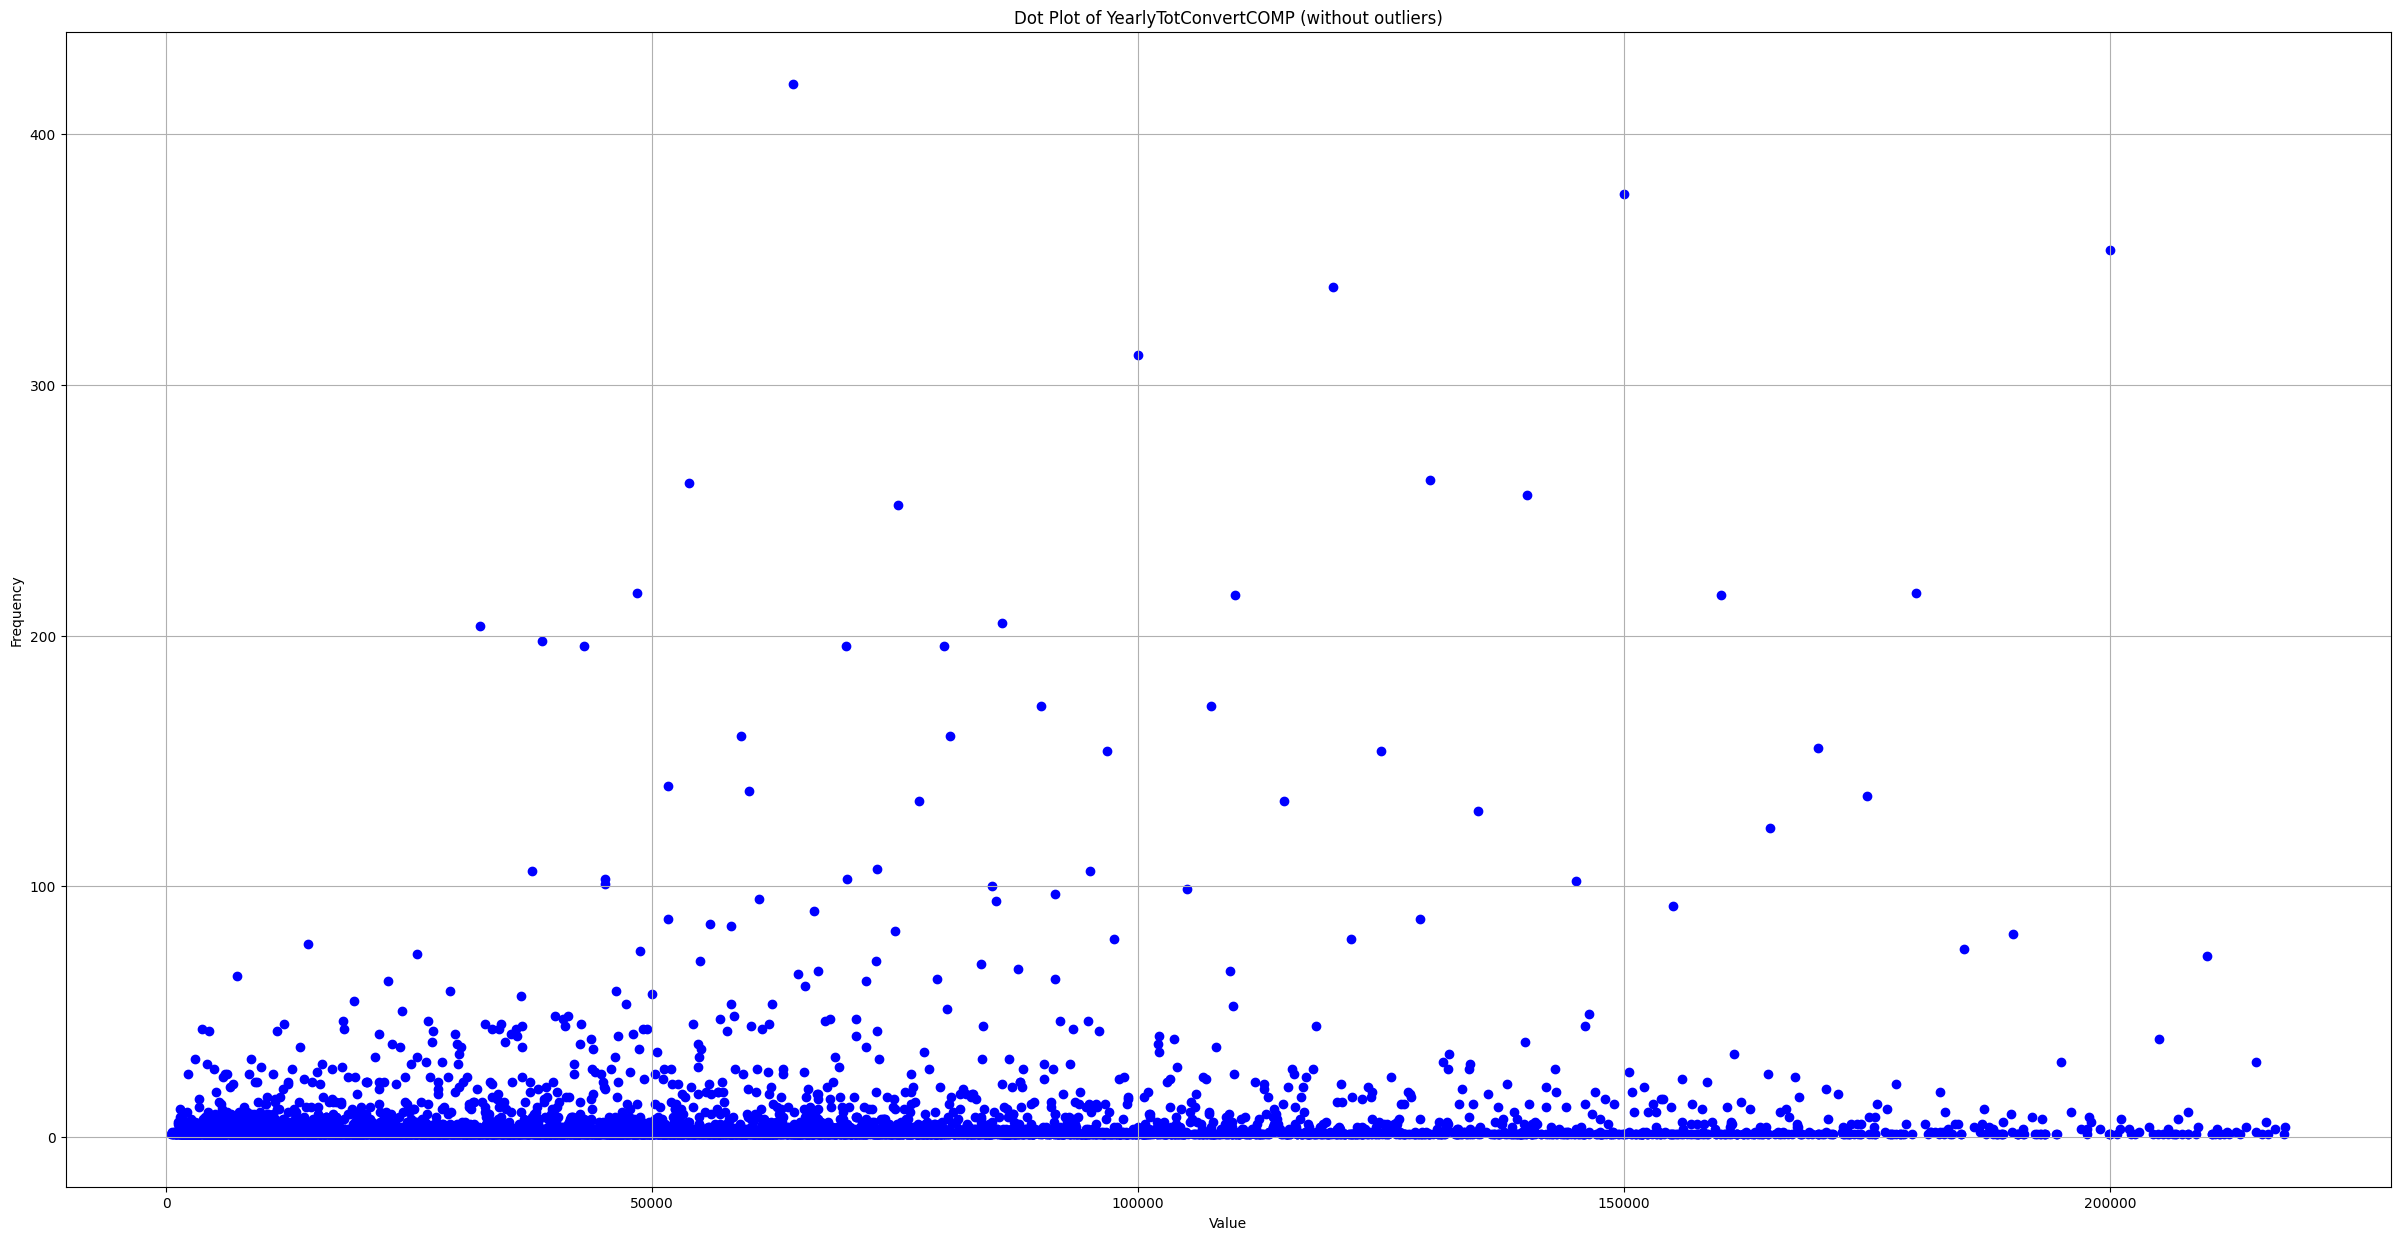

In [14]:
print(df_whole_45_salary.shape)
df_whole_45_salary['YearlyTotConvertCOMP'].value_counts()
#looking for why upper and lower bound are NAN
#df_salary_test['YearlyTotConvertCOMP'].isna().sum()
df_whole_45_salary.dropna(subset=['YearlyTotConvertCOMP'], inplace=True)


data = df_whole_45_salary['YearlyTotConvertCOMP']

#print(data.sort_values())
# Calculate the interquartile range (IQR)
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1

# Define the lower and upper bounds to filter outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# messing around with bounds
print(upper_bound) #255357.14285714287
print(lower_bound) #-92261.90476190478 subbing in zero becuase this is not helpful


# Filter the data to exclude outliers
filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

print(filtered_data)

# Create the dot plot
plt.figure(figsize=(30, 15))  # Adjust the figure size as needed
plt.scatter( filtered_data.value_counts().index.tolist(),filtered_data.value_counts().tolist(), color='b')

# Customize the plot
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.title('Dot Plot of YearlyTotConvertCOMP (without outliers)')

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

In [15]:
# Get top listed language used, NOTE--This is not very interesting, nearly all JavaScript and HTML/CSS.
# please note this cell is mostly unused and being saved for possible later use/ records. The results of this exploration 
# will not be reported on.

#print(df_whole_45['LanguageHaveWorkedWith'].unique())
#df_whole_45['LanguageHaveWorkedWith'] = df_whole_45['LanguageHaveWorkedWith'].str.replace(',', ';')
#country_grp = df_whole_45.groupby(['Country'])
#country_grp = country_grp.apply({'LanguageHaveWorkedWith': lambda x: x.str.split(',')})
#print(country_grp['LanguageHaveWorkedWith'].value_counts())


df_whole_45['LanguageHaveWorkedWith'] = df_whole_45['LanguageHaveWorkedWith'].str.replace(',', ';')
#country_grp = df_whole_45.groupby('Country')['LanguageHaveWorkedWith'].apply(lambda x: x.str.split(';').explode().value_counts())
#print(country_grp.head(75))

country_grp = df_whole_45.groupby('Country')['LanguageHaveWorkedWith'].apply(lambda x: x.str.split(';').explode().value_counts())
top_languages = country_grp.groupby(level=0).nlargest(3)
#top_languages.head(75)

#df_whole_45['LanguageHaveWorkedWith'] = df_whole_45['LanguageHaveWorkedWith'].str.replace(';', ',')

#country_grp = df_whole_45.groupby(['Country'])
#country_grp = country_grp.apply({'LanguageHaveWorkedWith': lambda x: x.str.split(',')})
#country_grp
#country_grp = country_grp.explode('LanguageHaveWorkedWith')
#counts = country_grp['LanguageHaveWorkedWith'].value_counts()

#country_grp['LanguageHaveWorkedWith'].value_counts()
#print(counts)


# make a copy of the DataFrame
#df_whole_45_copy = df_whole_45.copy()



# Split the values in the 'CodingActivities' column by the delimiter ';'
#country_grp = country_grp.agg({'LanguageHaveWorkedWith': lambda x: x.str.split([';',','])})



# Use the explode() method to create a new row for each value in the resulting lists


# Use the value_counts() method to count the occurrence of each value
#counts = country_grp['LanguageHaveWorkedWith'].value_counts()

#print(counts)

In [16]:
# This cell looks at the most used language, it is not by country. Looking at it by country did not do anything interesting nearly all JavaScript and HTML/CSS. 
# make a copy of the DataFrame
df_Lang = df.copy()

# Replace ';' with ','
df_Lang['LanguageHaveWorkedWith'] = df_Lang['LanguageHaveWorkedWith'].str.replace(';', ',')

# Split the 'LanguageHaveWorkedWith' column by ',' and explode the resulting list
df_Lang = df_Lang.assign(LanguageHaveWorkedWith=df_Lang['LanguageHaveWorkedWith'].str.split(',')).explode('LanguageHaveWorkedWith')

# Group by 'LanguageHaveWorkedWith', and count the occurrences
df_Lang = df_Lang.groupby(['LanguageHaveWorkedWith']).size().reset_index(name='Count')

# Sort by 'Count' in descending order
df_Lang = df_Lang.sort_values(['Count'], ascending=[False])

# Preview the resulting dataframe
#print(df_Lang.head(75))

<Axes: xlabel='YearlyTotConvertCOMP', ylabel='YearsCode'>

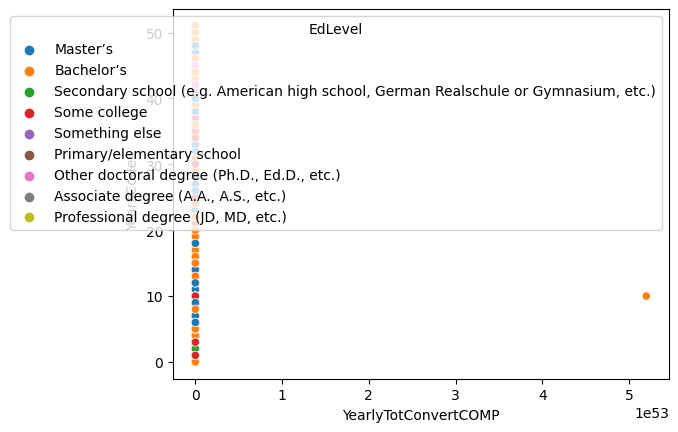

In [17]:
df_whole_45
sns.scatterplot(x = 'YearlyTotConvertCOMP', y = 'YearsCode', data = df_whole_45, hue = 'EdLevel' )

I want to look at a the top listed resposibilities by (contains developer), I think exploading it out makes it look like there are less developers, especially when it is put in percentages

In [18]:
# get top listed job (MainBranch):
#This is less intersting when devided by country, I want to make a pie chart of participation by listed responsibilites/job title.
df['DevType'].value_counts().head(40)
 
# make a copy of the DataFrame
df_copy = df.copy()

# drop NaN values
df_copy = df_copy.dropna(subset=['DevType'])

# Split the values in the 'CodingActivities' column by the delimiter ';'
df_copy['DevType'] = df_copy['DevType'].str.split(';')

# Use the explode() method to create a new row for each value in the resulting lists
df_copy = df_copy.explode('DevType')

# Use the value_counts() method to count the occurrence of each value
counts = df_copy['DevType'].value_counts()


# Divide each count by the total number of responses and multiply by 100 to get the percentage
percentages = (counts / len(df_copy)) * 100


print(percentages)


Developer, full-stack                           17.42
Developer, back-end                             16.14
Developer, front-end                             9.66
Developer, desktop or enterprise applications    5.79
Developer, mobile                                4.63
DevOps specialist                                3.74
Student                                          3.40
Cloud infrastructure engineer                    3.21
Database administrator                           2.99
System administrator                             2.98
Developer, embedded applications or devices      2.38
Project manager                                  2.36
Designer                                         2.28
Engineer, data                                   2.18
Engineering manager                              2.17
Data scientist or machine learning specialist    2.08
Data or business analyst                         1.94
Developer, QA or test                            1.88
Academic researcher         

In [19]:
# Count the rows containing 'Developer' in the 'DevType' column
count = df['DevType'].str.contains('Developer').sum()

# Print the count
print(f"Total number of rows containing 'Developer': {count}")

# Count the total number of non-null rows in the 'DevType' column
total_non_na_rows = df['DevType'].count()

# Print the count
print(f"Total number of non-null rows in 'DevType': {total_non_na_rows}")

#Print percent developers

perc = (count/total_non_na_rows)*100

print(f"Percentage Developers: {perc:.2f}%")


Total number of rows containing 'Developer': 51926
Total number of non-null rows in 'DevType': 61302
Percentage Developers: 84.71%


In [20]:
#taking a look at df_45
# gitting it ready for viewing in report file as a table
#df_45['Count'].sum() # answer is 64084

#df_45.columns 
#output :Index(['Country', 'Count', 'fully_remote_perc', 'Work_Location Count_nonNA', 'Mean Salary', 'Median Salary', 
#'Salary_Count NonNA', 'Mean YearsCode', 'Median YearsCode', 'YearsCode_Count NonNA', 'Mean Age', 'Age_Count NonNA', 
#'Most_Common ED_Level', 'Ed_level Count NonNA'],
   #   dtype='object')
    

#getting counts in percentages
    
df_45['Work_Loc Participation'] = df_45['Work_Location Count_nonNA']/df_45['Count']
df_45.loc[:, 'Work_Loc Participation'] =df_45['Work_Loc Participation'].map('{:.2%}'.format)

df_45['Salary Participation'] = df_45['Salary_Count NonNA']/df_45['Count']
df_45.loc[:, 'Salary Participation'] =df_45['Salary Participation'].map('{:.2%}'.format)

df_45['YC P'] = df_45['YearsCode_Count NonNA']/df_45['Count']
df_45.loc[:, 'YC P'] =df_45['YC P'].map('{:.2%}'.format)

df_45['Age P'] = df_45['Age_Count NonNA']/df_45['Count']
df_45.loc[:, 'Age P'] =df_45['Age P'].map('{:.2%}'.format)

df_45['ED P'] = df_45['Ed_level Count NonNA']/df_45['Count']
df_45.loc[:, 'ED P'] =df_45['ED P'].map('{:.2%}'.format)


df_45['Fully Remote'] = df_45['fully_remote_perc'].map('{:.2%}'.format)

df_45['Mean Salary'] = df_45['Mean Salary'].map('${:,.2f}'.format)
df_45['Median Salary'] = df_45['Median Salary'].map('${:,.2f}'.format)

# I am removing the below because the values are really too small to be visual. May be better represented by a bar graph?
#df_45["participation"] = df_45['Count']/64084
    
# rearrange/remove extra columns
# remove some of tehh participation columns they are all almost the same. It looks like if someone was willing to answer the salary question they answered the rest.
#['Country', 'Count','Fully Remote','Work_Loc P','Mean Salary', 'Median Salary','Sal P', 'Mean YearsCode', 'Median YearsCode','YC P','Mean Age','Age P','Most_Common ED_Level','ED P'
df_45_clean = df_45[['Country', 'Count','Fully Remote','Work_Loc Participation','Mean Salary', 'Median Salary','Salary Participation', 'Mean YearsCode', 'Median YearsCode','Mean Age','Most_Common ED_Level']]

df_45_clean.set_index('Country', inplace=True)



In [21]:
#Sending df_45_clean to CSV
df_45_clean.to_csv("df_45_clean.csv", index=True)
display(df_45_clean)
#Sending df_whole_45 to CSV
df_whole_45.to_csv('df_whole_45.csv', index = False)

#Sending df_salary_test to CSV
df_salary_test.to_csv('df_salary_test.csv', index = False) # this is an uncleaned copy of original for use in Salry.ipynb

#Sending df_whole_45_salary to CSV
df_whole_45_salary.to_csv('df_whole_45_salary.csv', index = False) #cleaned copy, filtered for outliers
#df_whole_45_salary.shape # output (31624, 83) looks good like filters worked!

,Count,Fully Remote,Work_Loc Participation,Mean Salary,Median Salary,Salary Participation,Mean YearsCode,Median YearsCode,Mean Age,Most_Common ED_Level
Country,,,,,,,,,,
USA,13543,58.23%,85.87%,"$149,585.50","$140,000.00",58.91%,15.60,12.00,34.80,Bachelor’s
India,6639,39.84%,73.79%,"$19,855.80","$14,579.00",29.13%,7.00,6.00,26.20,Bachelor’s
Germany,5395,34.39%,83.97%,"$69,800.20","$66,666.70",49.75%,13.50,10.00,31.40,Master’s
UK of GB and N.Ireland,4190,42.85%,85.32%,"$77,805.50","$73,170.70",52.74%,15.70,12.00,33.80,Bachelor’s
Canada,2490,62.40%,84.18%,"$88,517.60","$83,608.00",53.53%,14.20,11.00,33.20,Bachelor’s
France,2328,23.03%,83.93%,"$53,364.00","$49,462.40",53.61%,12.20,10.00,30.70,Master’s
Brazil,2109,66.77%,88.62%,"$31,723.30","$24,000.00",58.27%,11.30,10.00,30.90,Bachelor’s
Poland,1732,54.61%,83.83%,"$50,475.50","$44,692.50",54.39%,10.90,9.00,29.30,Master’s
Netherlands,1555,18.74%,85.79%,"$70,275.30","$64,516.10",53.50%,14.10,11.00,32.30,Bachelor’s


In [22]:
# currently broken!

def color_coding(value):
    if isinstance(value, str):
        return 'background-color: {}'.format(value)
    
    if value <= 0.25:
        return 'background-color: red'
    elif value <= 0.50:
        return 'background-color: yellow'
    elif value <= 0.75:
        return 'background-color: green'
    else:
        return 'background-color: darkgreen'

# Apply the color coding function to the DataFrame
df_styled = df_45_clean.style.applymap(color_coding, subset=['Work_Loc P','Sal P','YC P','Age P','ED P'])

# Display the styled DataFrame



#df_styled.loc[:, 'Work_Loc P'] =df_45['Work_Loc P'].map('{:.2%}'.format)


#df_styled.loc[:, 'Sal P'] =df_45['Sal P'].map('{:.2%}'.format)


#df_styled.loc[:, 'YC P'] =df_45['YC P'].map('{:.2%}'.format)


#df_styledloc[:, 'Age P'] =df_45['Age P'].map('{:.2%}'.format)


#df_styled.loc[:, 'ED P'] =df_45['ED P'].map('{:.2%}'.format)



# Save the DataFrame to a html file
#df_styled.to_html("df_styled.html", index=False) ##done


#df_styled

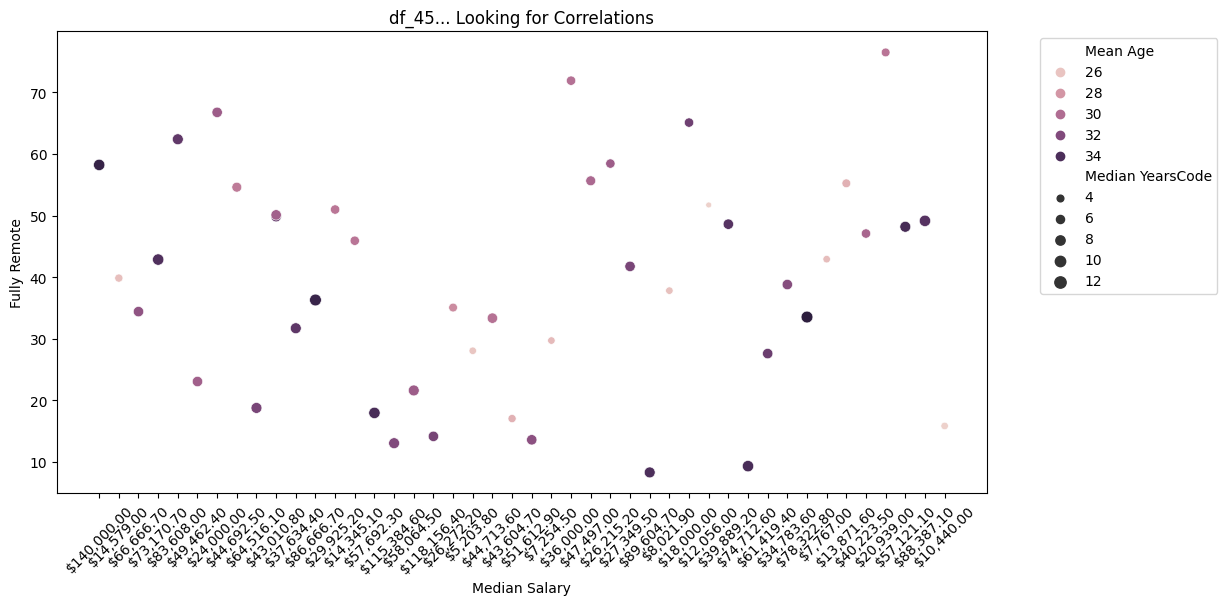

In [31]:

# Create a copy of the DataFrame so it is a temporary change
df_copy = df_45.copy()

# Set the figure size to be wider than tall
plt.figure(figsize=(12, 6))  # Set the figure size to be wider than it is tall

# Remove the percentage symbol from the "Fully Remote" column
df_copy['Fully Remote'] = df_copy['Fully Remote'].str.rstrip('%')

# Convert the "Fully Remote" column from string to float in the copied DataFrame
df_copy['Fully Remote'] = df_copy['Fully Remote'].astype(float)

# Plot the scatterplot 
#sns.scatterplot(x='Median Salary', y='Mean Age', data=df_copy, hue='Fully Remote', size='Median YearsCode')

# Plot the scatterplot with the 
sns.scatterplot(x='Median Salary', y='Fully Remote', data=df_copy, hue='Mean Age', size='Median YearsCode')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Set the title of the plot
plt.title('df_45... Looking for Correlations')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

# This is not very interesting by country, there are two many factors that are averaged. 
# General trend to have more years codeing for age.  

In [24]:
# make a copy of the DataFrame
df_copy = df.copy()

# Replace NaN values with an empty string
df_copy['CodingActivities'] = df_copy['CodingActivities'].fillna('')

# Split the values in the 'CodingActivities' column by the delimiter ';'
df_copy['CodingActivities'] = df_copy['CodingActivities'].str.split(';')

# Use the explode() method to create a new row for each value in the resulting lists
df_copy = df_copy.explode('CodingActivities')

# Use the value_counts() method to count the occurrence of each value
counts = df_copy['CodingActivities'].value_counts()

print(counts)

Hobby                                 42922
Contribute to open-source projects    15378
                                      14369
Freelance/contract work               13305
School or academic work                8561
Bootstrapping a business               8401
I don’t code outside of work           7311
Other (please specify):                2179
Name: CodingActivities, dtype: int64
